### Попытка окна №1 (размерности странные и величины)

In [198]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift, fftfreq

nx_max = 1500
ny_max = 60
dt_step = 0.001
x_frac_start = 0.3 
x_frac_end = 0.8
t_start = 0.7

In [199]:
filename = f"./data/s2d_film_time_statistic_{nx_max}_{ny_max}.dat"
with open(filename, "r") as f:
    first_line = f.readline().strip()
    dx_step = float(first_line)

tf_ind = int(t_start/dt_step)
xf_ind = int(x_frac_start*nx_max)
xl_ind = int(x_frac_end*nx_max)
data = np.loadtxt(filename, skiprows=2, delimiter=',')
data = data[:, 1:]*1.0e3 

In [200]:

#Попытка 2D-анализа для сигнала в каждой отдельной точке с выводом на график
#список с значениям получившихся длин волн в точках от 0 до 1500
lenght_waves = list()
#список с значениям получившихся частот в точках от 0 до 1500
freq_waves = list()
#список с значениям получившихся фазовых скоростей в точках от 0 до 1500
uw_waves = list()
#координаты для графика
x_positions = list()

window_size_x = 25
step_x = 1
for start_x in range(0, nx_max - window_size_x + 1, step_x):
    end_x = start_x + window_size_x
    data_window = data[:, start_x:end_x]
    data_detrend = data_window - np.mean(data_window, axis=1, keepdims=True)
    nt, nx_local = data_detrend.shape
    #тут 2D FFT
    win_t = np.hanning(nt)[:, None]
    win_x = np.hanning(nx_local)[None, :]
    data_win = data_detrend * win_t * win_x
    spec2 = fftshift(fft2(data_win))
    power = np.abs(spec2)**2 
    freqs = fftshift(fftfreq(nt, d=dt_step))     # шт / t-ед.
    wavenums = fftshift(fftfreq(nx_local, d=dt_step))  # шт / x-ед
    power_flat = power.copy()
    peak_idx = np.unravel_index(np.argmax(power_flat), power_flat.shape)
    f_peak = freqs[peak_idx[0]]
    k_peak = wavenums[peak_idx[1]]
    if k_peak != 0:
        u_phase = f_peak / k_peak
    else:
        u_phase = np.nan
    lambda_phys = 1 / (k_peak / dx_step)       # длина волны, м
    freq_phys = f_peak / dt_step                     # частота, Гц
    u_phys = freq_phys * lambda_phys            # фазовая скорость, м/с
    x_center = start_x + window_size_x // 2
    x_positions.append(x_center)
    #обработка
    lenght_waves.append(np.abs(lambda_phys*100) if not np.isnan(lambda_phys) else 0)
    freq_waves.append(np.abs(freq_phys) if not np.isnan(freq_phys) else 0)
    uw_waves.append(np.abs(u_phys*100) if not np.isnan(u_phys) else 0)

In [201]:
#set(list(lenght_waves))

In [202]:
#set(list(freq_waves))

In [203]:
#set(list(uw_waves))

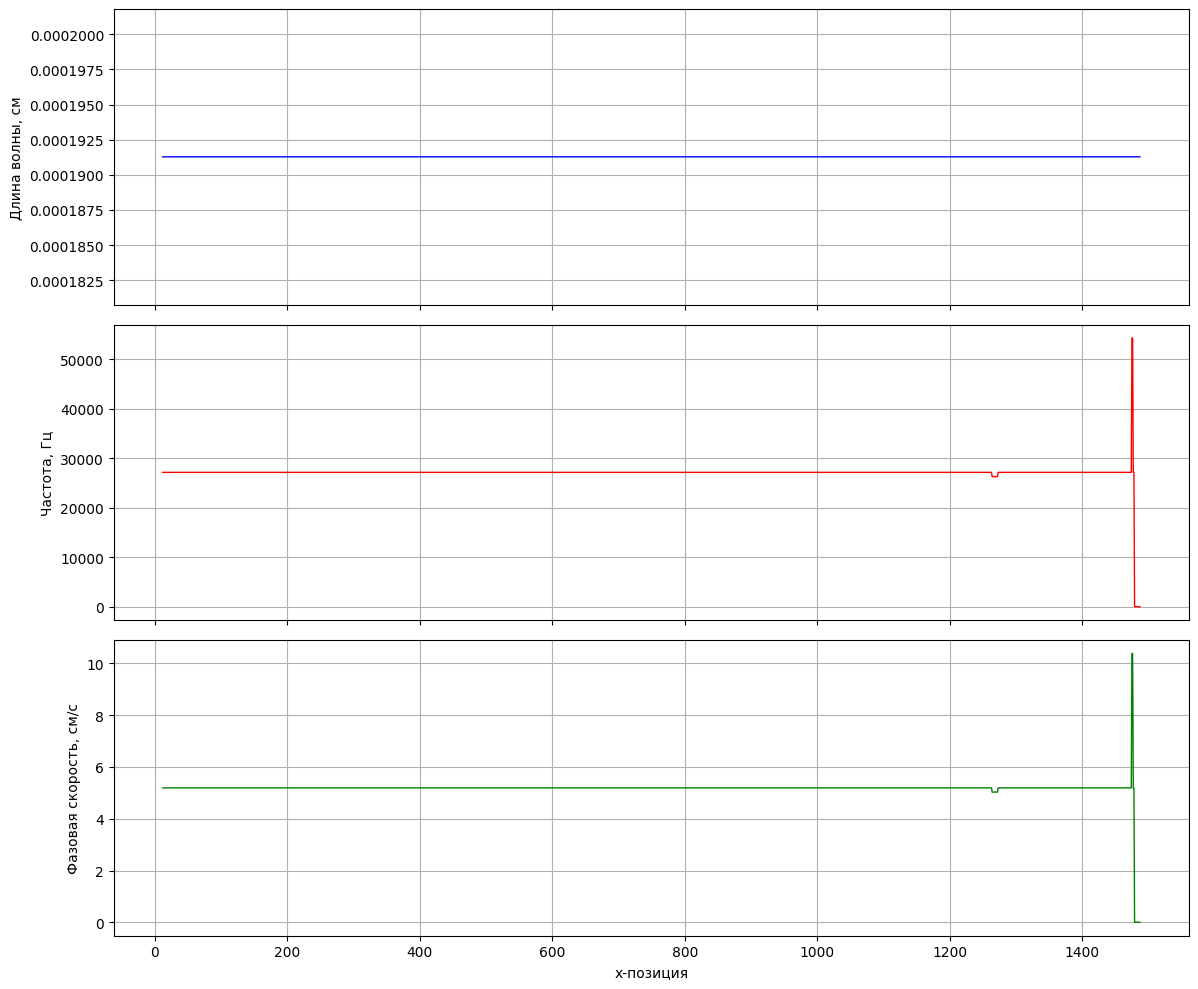

In [204]:
lenght_waves = np.array(lenght_waves)
freq_waves = np.array(freq_waves)
uw_waves = np.array(uw_waves)

# ymin0, ymax0 = 0.815, 0.825
# ymin1, ymax1 = 27.0, 27.1
# ymin2, ymax2 = 21., 23.

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
axes[0].plot(x_positions, lenght_waves, 'b-', linewidth=1)
axes[0].set_ylabel('Длина волны, см')
#axes[0].set_ylim(ymin0, ymax0)
axes[0].grid(True)
axes[1].plot(x_positions, freq_waves, 'r-', linewidth=1)
axes[1].set_ylabel('Частота, Гц')
#axes[1].set_ylim(ymin1, ymax1)
axes[1].grid(True)
axes[2].plot(x_positions, uw_waves, 'g-', linewidth=1)
axes[2].set_ylabel('Фазовая скорость, см/с')
axes[2].set_xlabel('x-позиция')
#axes[2].set_ylim(ymin2, ymax2)
axes[2].grid(True)
plt.tight_layout()
plt.show()

### Поиск максимальной амплитуды в каждой точке

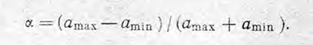

In [229]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd

nx_max = 1500
ny_max = 60
dt_step = 0.001
x_frac_start = 0.3 
x_frac_end = 0.8
t_start = 0.7

In [230]:
filename = f"./data/s2d_film_time_statistic_{nx_max}_{ny_max}.dat"
with open(filename, "r") as f:
    first_line = f.readline().strip()
    dx_step = float(first_line)
tf_ind = int(t_start/dt_step)
xf_ind = int(x_frac_start*nx_max)
xl_ind = int(x_frac_end*nx_max)
data = np.loadtxt(filename, skiprows=2, delimiter=',')
data_time = data[:, 0]
data = data[:, 1:]*1.0e3

#### Для последнего момента времени

Размер x_coords: (1500,)
Размер data_slice: (1500,)


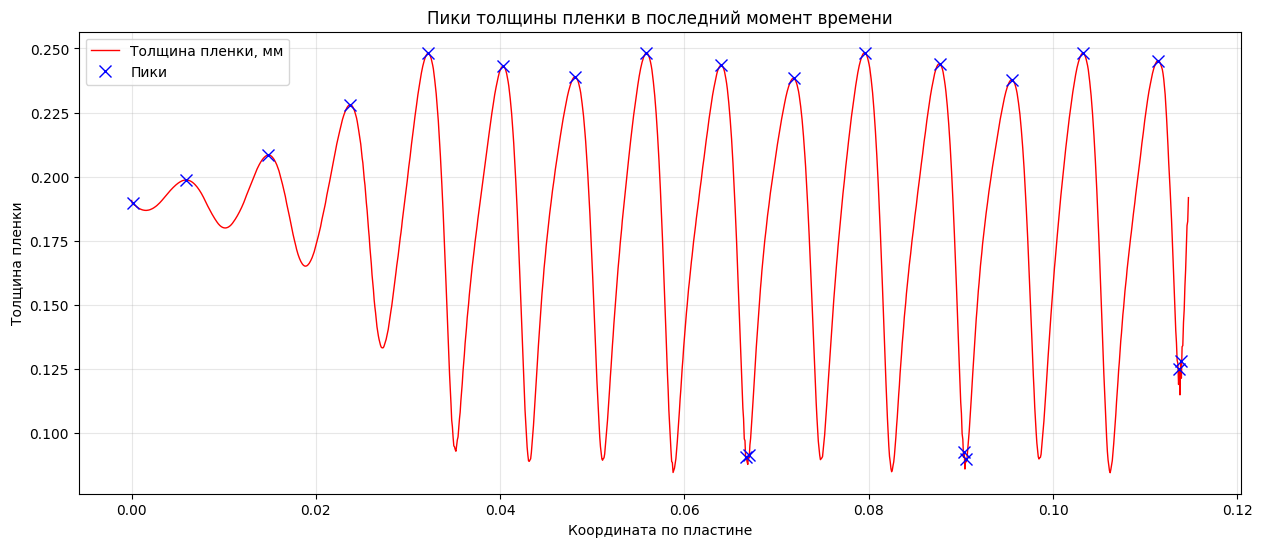

In [231]:
time_slice = -1  #последний момент времени
data_slice = data[time_slice, :]  #массив по пространству
peaks_ind = []
peaks_values = []
#находим пики по пространственной координате
peaks, properties = find_peaks(data_slice)
peaks_ind.append(peaks)
peaks_values = data_slice[peaks]
x_coords = np.arange(0, dx_step * len(data_slice), dx_step)
print(f"Размер x_coords: {x_coords.shape}")
print(f"Размер data_slice: {data_slice.shape}")
plt.figure(figsize=(15, 6))
plt.plot(x_coords, data_slice, 'r-', linewidth=1, label='Толщина пленки, мм')
plt.plot(x_coords[peaks], peaks_values, 'xb', markersize=8, label='Пики')
plt.xlabel('Координата по пластине')
plt.ylabel('Толщина пленки')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title(f'Пики толщины пленки в последний момент времени')
plt.show()

#### Для всех времен

In [ ]:
peaks_ind = []
peaks_values = []
x_coords = []
max_peaks = []
min_peaks = []
for i in range(len(list(data_time))):
    data_slice = data[i, :]  #массив по пространству
    peaks, properties = find_peaks(data_slice)
    peaks_ind.append(peaks)
    peaks_values.append(data_slice[peaks])
    #есть ли пик
    if len(peaks) > 0:
        current_peaks = data_slice[peaks]
        peaks_values.append(current_peaks)
        max_peaks.append(np.max(current_peaks))
        min_peaks.append(np.min(current_peaks))
    else:
        #nan
        peaks_values.append(np.array([]))
        max_peaks.append(np.nan)
        min_peaks.append(np.nan)
x_coords = np.arange(0, dx_step * len(data_slice), dx_step)